# Histogrammes

Ce notebook est une introduction à la notion d'histogramme. A la fin, vous aurez vu:
* comment afficher un histogramme,
* comment programmer une fonction histogramme,
* comment améliorer le rendu d'une image si les contraste ne sont pas suffisants.

Pour simplifier la compréhension, les images utilisées seront en noir et blanc. Les images en couleurs sont plus difficiles à manipuler, aussi bien d'un point de vue conceptuel que mathématiques. Les techniques présentées ici pourront être appliquées sur les 3 canaux d'une image en couleurs, séparément, mais le résultat visuel n'est pas toujours garanti.

Nous utiliserons le module ``skimage`` pour ces fonctions d'histogramme et de transformations de l'exposition des images.



In [28]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import skimage.exposure as expo

# 1. Afficher un histogramme

L'histogramme d'une image est la représentation du nombre de pixels (en ordonnée) pour une intensité de niveaux de gris donnée (en abscisse).

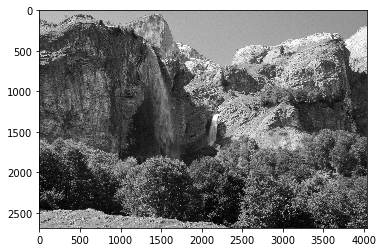

In [12]:
# Chargement d'une image 
# Photo d'origine de Romaric Juvanon, modifiée pour l'assombrir
P = imageio.imread('boret2.jpg')
P = P[:,:,1]
plt.imshow(P, cmap=plt.cm.gray)
plt.show()

In [3]:
# Vérification du type d'images et de sa taille
print(P.dtype)
print(P.shape)

uint8
(2683, 4040)


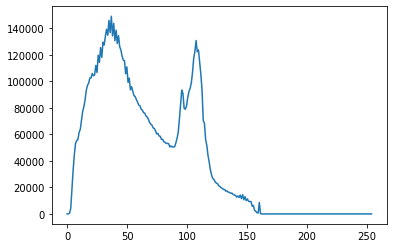

In [11]:
# Calcul de l'histogramme
h,bins = np.histogram(P.flatten(), 256, range=(0,255))
plt.plot(bins[:-1], h)
plt.show()

# 2. Modification de l'histogramme

Cette image est très sombre: il n'y a pas de pixels dont l'intensité est supérieure à 160 (environ). Soit $m$ la plus petite intensité dans l'image, $M$ la plus grande. L'objectif est de trouver une transformation linéaire $f(x)=a\cdot x +b$ qui va modifier les intensités de chaque pixel, et pour laquelle:
$$f(m)=0 \textrm{ et } f(M)=255$$

1. Poser et résoudre le système de deux équations à deux inconnues (trouver $a$ et $b$ en fonction de $m$ et $M$).
2. Appliquer la transformation à l'image P

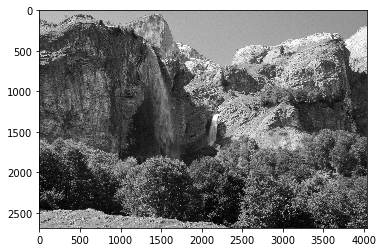

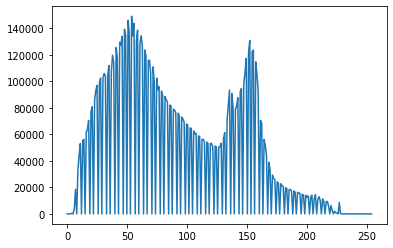

In [16]:
# les valeurs de a et b doivent être changées
a = 1.4
b = 2

# la transformation est appliquée à tous les pixels de P
# le langage permet de ne pas réaliser une boucle pour ce type d'opérations
P2 = a*P+b
plt.imshow(P2, cmap=plt.cm.gray)
plt.show()

# Calcul de l'histogramme pour observer le résultat
h,bins = np.histogram(P2.flatten(), 256, range=(0,255))
plt.plot(bins[:-1], h)
plt.show()

## Commentaire

Cette opération est appelée étirement d'histogramme. La plage de valeurs utilisée devient maximale, de 0 à 255. Du fait de l'utilisation de valeurs entières, les arrondis dans les calculs sont visibles (l'histogramme n'est pas une jolie courbe, mais revient régulièrement à 0).

# 3. Effet de saturation

La méthode suivante introduit un effet de saturation. Soit $I$ l'image considérée, et $p$ un pixel. Posons $r$ la valeur:
$$r=(m+M)/2$$
avec $m$ la plus petite intensité de $I$, et $M$ la plus grande.

L'image $I$ est transformée en l'image notée $I_2$ de la manière suivante:
1. Si $I(p)>r$, alors $I_2(p) = M$
2. Si $I(p)<4r/3$, alors $I_2(p)= m$
3. Sinon, $I_2(p)=I(p)$

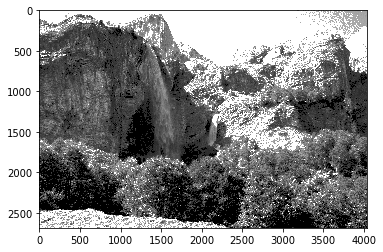

In [38]:
# Chargement de l'image
I = imageio.imread('boret.jpg')
I = I[:,:,1]

# Calcul des min et max sur l'image
m = np.min(I).astype(np.int)
M = np.max(I).astype(np.int)

# Calcul de la valeur de référence
r = (m+M)/2

# Pas besoin de faire de boucle
I2 = np.copy(I);
I2[I2<r/3] = m
I2[I2>4*r/3] = M

plt.imshow(I2, cmap=plt.cm.gray)
plt.show()

# 3. Coder sa propre fonction histogramme

Nous l'avons vu, l'histogramme consiste à compter le nombre de pixels ayant une intensité donnée. L'algorithme consiste donc à:
1. Créer un tableau ``h`` de 256 valeurs, toutes initialisées à 0.
2. Parcourir l'ensemble des pixels de l'image:
    * Pour un pixel, récupérer le niveau de gris, noté $i$ (comme intensité)
    * Ajouter 1 à ``h[i]``
3. L'histogramme est calculé

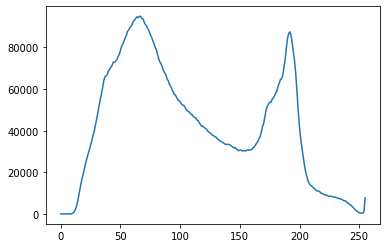

In [41]:
def histo(I):
    # Créer un tableau h de 256 valeurs, toutes initialisées à 0
    h = np.zeros((256, 1), dtype=np.int)
    X,Y = I.shape
    
    # Parcourir l'ensemble des pixels de l'image
    for m in range(X):
        for n in range(Y):
            # Récupérer le niveau de gris, noté i
            i = I[m,n]
            
            # Ajouter 1 à h[i]
            h[i] = h[i] + 1
    
    plt.plot(range(256), h)
    plt.show()
    return h

histo(I)

# 4. Appliquer une transformation non linéaire

Sur le modèle de l'étirement d'histogramme, la fonction suivante donne des résultats intéressants:

$$f(x)=\frac{1}{1+(m/x)^s} $$
avec $x$ l'intensité de l'image, $m$ une valeur pivot (par exemple, la valeur moyenne des intensités), et $s$ un coefficient qui permet de jouer sur l'effet de saturation.

1. Coder la fonction décrite ci-dessus.
2. Appliquer cette transformation à une image et tester différentes valeurs de E.

In [56]:
def contrast_stretching(I, s):
    # epsilon sert à éviter une division par 0
    epsilon = 0.0001
    
    m = np.mean(I);
    I = I.astype(np.float)
    Ic = 1 / (1+(m/(I+epsilon))**s )
    return Ic


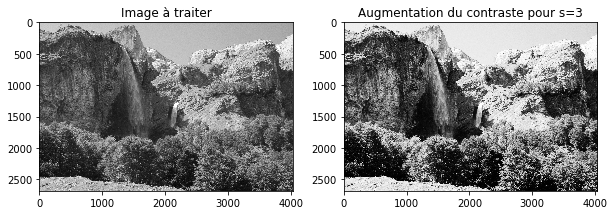

In [57]:
s=3
Ic = contrast_stretching(I, s)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(I, cmap=plt.cm.gray)
plt.title('Image à traiter')
plt.subplot(122)
plt.imshow(Ic, cmap=plt.cm.gray)
plt.title('Augmentation du contraste pour s='+str(s))
plt.show()

# 5. Egalisation d'histogramme

La fonction d'égalisation d'histogramme permet de rapprocher l'histogramme d'une valeur constante. L'objectif est de répartir au mieux les niveaux de gris sur l'ensemble des valeurs possibles (à priori la plage 0-255).
Nous allons utiliser la fonction ``skimage.exposure.equalize_hist`` et vérifier l'impact sur l'histogramme de l'image.

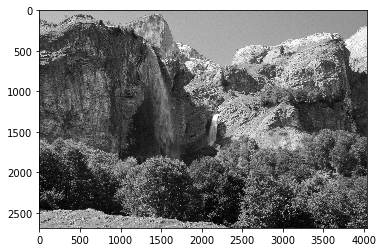

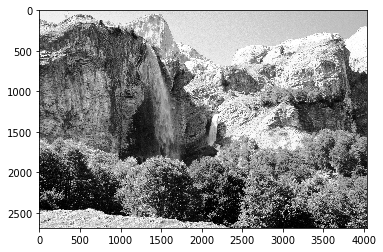

In [73]:
# l'egalisation d'histogramme est appliquée à l'image P, qui est plus foncée que l'image d'origine
Ie = expo.equalize_hist(P)
plt.imshow(P, cmap=plt.cm.gray)
plt.show()
plt.imshow(Ie, cmap=plt.cm.gray)
plt.show()

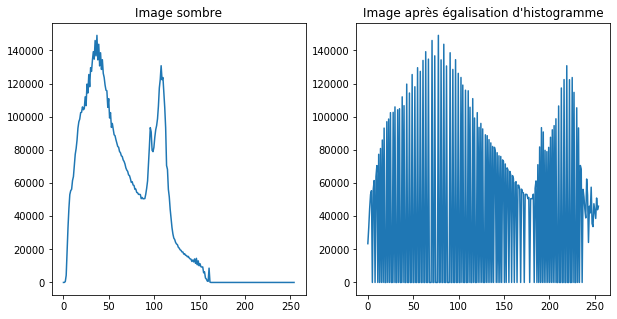

In [78]:
h0,bins = np.histogram(P, 256, range=(0,255))
h,bins = np.histogram(255*Ie, 256, range=(0,255))

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(bins[:-1], h0)
plt.title('Image sombre')
plt.subplot(122)

plt.plot(bins[:-1], h)
plt.title("Image après égalisation d'histogramme")

plt.show()